**Transfer learning 1**

faces from the wild (scraped from google images) dataset trained on top of the FER2013 model with extra added layers.

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.models import load_model

from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


import cv2

Using TensorFlow backend.


In [3]:
path='drive/My Drive/Facial-Expression-Detection-V2'
print(os.listdir(path))

['3.jpg', 'face_crop.py', '2.jpg', '.gitignore', 'LICENSE', '1.jpg', 'haarcascade_frontalface_alt.xml', 'README.md', '.ipynb_checkpoints', 'data', 'fer2013', '.git', 'photo.jpg', 'capture.jpg', 'FED_transfer.ipynb', 'FED.ipynb']


In [4]:
# load model trained with FER2013
model_fer2013 = load_model(path+'/data/model25.h5')
model_fer2013.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)        

In [6]:
model = Sequential()
# transfer all the layers except the last "dense" layer
for layer in model_fer2013.layers[:-1]:
    model.add(layer)

#model.summary()

## get faces from the wild (scraped) dataset

In [7]:
#------------------------------
#cpu - gpu configuration
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 8 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
#sess = tf.Session(config=config) 
#keras.backend.set_session(config)
#------------------------------
#variables
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 512
epochs = 200
#------------------------------
# The scraped data was croped, resized and saved in FacesInTheWild.csv in the same format fer2013.csv were

with open(path+"/data/FacesInTheWild.csv") as f:
  content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

#------------------------------
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

#------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
      print("", end="")

#------------------------------
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#------------------------------

number of instances:  3136
instance length:  2304
2200 train samples
935 test samples


In [8]:
# freeze everything 
for layer in model.layers:
    layer.trainable = False
model.add(Dense(num_classes, activation='softmax', name="dense_output"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)        

In [9]:
#------------------------------
#batch process
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

#------------------------------

model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)

#------------------------------

fit = False

if fit == False:
    #model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
    model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs) #train for randomly selected one
else:
    model.load_weights(path+'/data/model_FIW.h5') #load weights from the faces in the wild optimized
 
#------------------------------
"""
#overall evaluation
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])
"""
#------------------------------
#function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
#------------------------------



Epoch 1/200
512/512 [==============================] - 25s 49ms/step - loss: 1.3787 - accuracy: 0.4880
Epoch 2/200
512/512 [==============================] - 19s 38ms/step - loss: 1.1464 - accuracy: 0.5819
Epoch 3/200
512/512 [==============================] - 19s 36ms/step - loss: 1.0764 - accuracy: 0.6044
Epoch 4/200
512/512 [==============================] - 19s 36ms/step - loss: 1.0389 - accuracy: 0.6152
Epoch 5/200
512/512 [==============================] - 19s 36ms/step - loss: 1.0198 - accuracy: 0.6210
Epoch 6/200
512/512 [==============================] - 19s 37ms/step - loss: 1.0110 - accuracy: 0.6254
Epoch 7/200
512/512 [==============================] - 18s 36ms/step - loss: 0.9989 - accuracy: 0.6285
Epoch 8/200
512/512 [==============================] - 19s 36ms/step - loss: 0.9878 - accuracy: 0.6310
Epoch 9/200
512/512 [==============================] - 18s 36ms/step - loss: 0.9860 - accuracy: 0.6311
Epoch 10/200
512/512 [==============================] - 18s 36ms/step - l

### **save and analyze Model**

In [ ]:
#Saving the model
model.save(path+'/data/model_FIW.h5')

In [ ]:
#Evaluation
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.6684360439127142
Train accuracy: 79.63636517524719
Test loss: 1.837412697427413
Test accuracy: 42.887699604034424


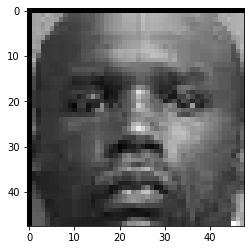

[0.48016673 0.04811184 0.28223908 0.00336467 0.09269452 0.00174934
 0.09167381]


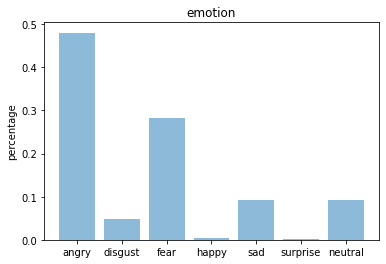

----------------------------------------------


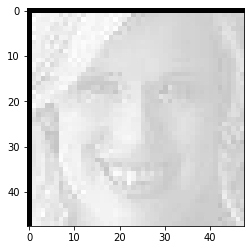

[0.0356472  0.14454234 0.01870043 0.19209518 0.45383263 0.00147691
 0.15370534]


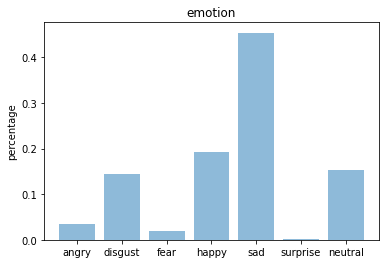

----------------------------------------------


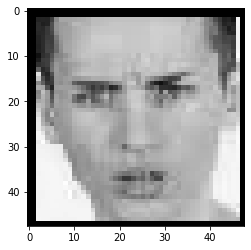

[0.30976406 0.63474524 0.00721842 0.00104771 0.00626133 0.00161455
 0.03934868]


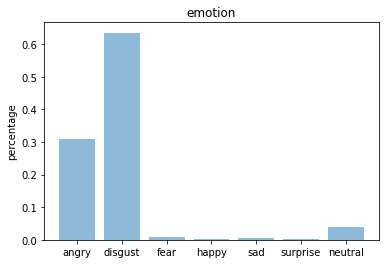

----------------------------------------------


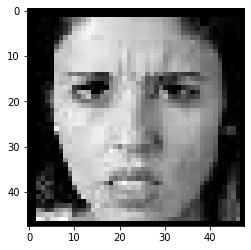

[0.3276076  0.13769047 0.12218575 0.04323195 0.17605898 0.04334515
 0.14988013]


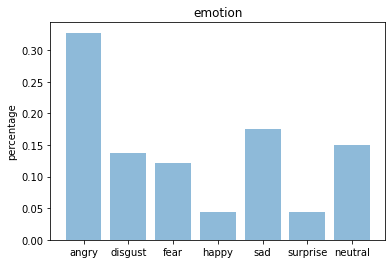

----------------------------------------------


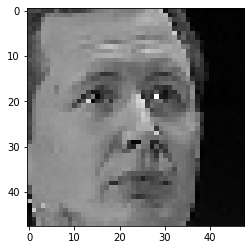

[0.10803539 0.08235236 0.13254932 0.0677067  0.28761214 0.15697646
 0.16476764]


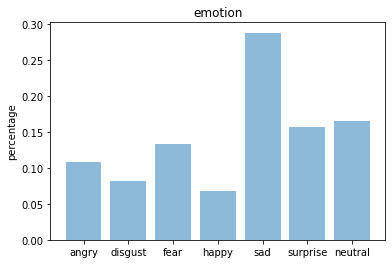

----------------------------------------------


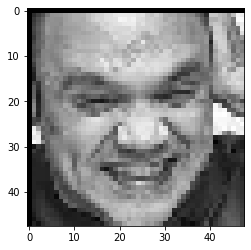

[1.4779813e-03 1.9516677e-02 3.3121585e-05 9.1868073e-01 2.2371274e-03
 2.2509051e-03 5.5803549e-02]


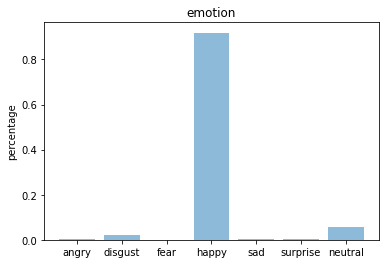

----------------------------------------------


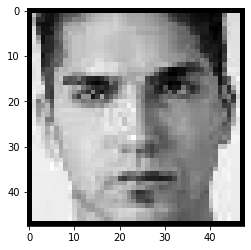

[1.0806506e-01 3.5185990e-01 1.6222365e-01 1.7938682e-08 3.5507101e-01
 1.8429608e-05 2.2761945e-02]


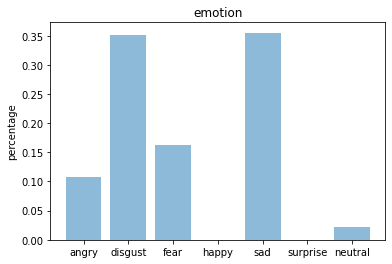

----------------------------------------------


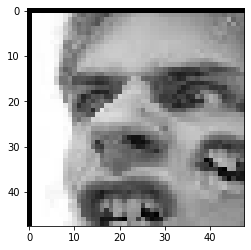

[0.05213099 0.03325512 0.01872217 0.27778175 0.05985738 0.54000264
 0.01825002]


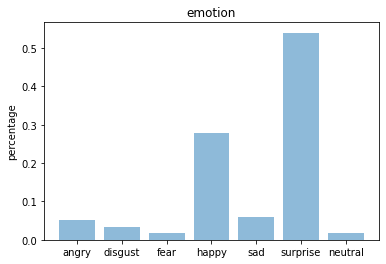

----------------------------------------------


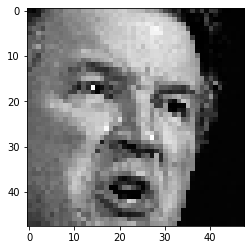

[7.2560483e-01 2.6025864e-01 4.7610742e-03 2.8068622e-04 5.2004270e-03
 2.7815034e-03 1.1127802e-03]


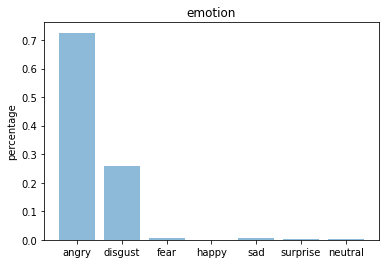

----------------------------------------------


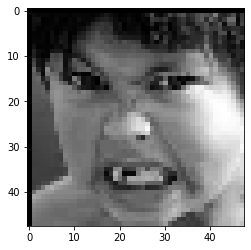

[7.6119995e-01 2.2418600e-01 5.4991856e-04 3.4598361e-03 1.8485773e-03
 4.3945955e-04 8.3162384e-03]


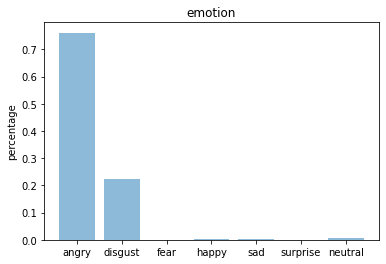

----------------------------------------------


In [ ]:
monitor_testset_results = True

if monitor_testset_results == True:
	#make predictions for test set
	predictions = model.predict(x_test)

	index = 0
	for i in predictions:
		if index < 30 and index >= 20:
			#print(i) #predicted scores
			#print(y_test[index]) #actual scores
			
			testing_img = np.array(x_test[index], 'float32')
			testing_img = testing_img.reshape([48, 48]);
			
			plt.gray()
			plt.imshow(testing_img)
			plt.show()
			
			print(i)
			
			emotion_analysis(i)
			print("----------------------------------------------")
		index = index + 1

In [ ]:
#Confusion Matrix.

from sklearn.metrics import classification_report, confusion_matrix
 
pred_list = []; actual_list = []
 
for i in predictions:
 
  pred_list.append(np.argmax(i))
 
for i in y_test:
 
  actual_list.append(np.argmax(i))
 
confusion_matrix(actual_list, pred_list)

array([[ 54,  26,   2,  14,  35,   6,  16],
       [ 26,  42,  12,  24,  23,   6,  10],
       [  9,   9,  23,   6,  13,  21,  15],
       [  6,   7,   2,  96,  12,  11,   7],
       [ 16,  16,   9,  12,  43,   3,  25],
       [  9,  12,   9,  14,   4, 103,   7],
       [ 15,  14,   4,  13,  29,   5,  40]])

In [ ]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [ ]:
#plot face function
def plotface(file):
  #file = path+'/1.jpg'
  true_image = image.load_img(file)
  img = image.load_img(file, grayscale=True, target_size=(48, 48))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  x /= 255

  custom = model.predict(x)
  emotion_analysis(custom[0])

  x = np.array(x, 'float32')
  x = x.reshape([48, 48]);

  plt.gray()
  plt.imshow(true_image)
  plt.show()

In [ ]:
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python


In [ ]:
#pip install -U imgaug==0.2.7

In [ ]:
def facecrop(image):  
    """
    Use pretrained HAAR cascade to detect the face and build a bounding box 
    """
    facedata = '/content/drive/My Drive/Facial-Expression-Detection-V2/haarcascade_frontalface_alt.xml'
    #facedata = path+"/haarcascade_frontalface_default.xml"
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite(path+'/capture.jpg', sub_face)
            print ("Writing: " + image)

    except Exception as e:
        print (e)

    #cv2.imshow(image, img)
    #plt.imshow(img)


facecrop(path+'/3.jpg')


Writing: drive/My Drive/Facial-Expression-Detection-V2/3.jpg


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


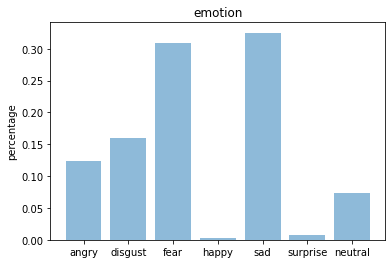

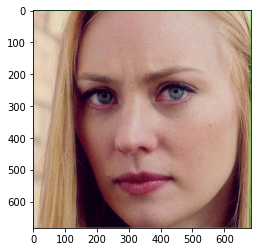

In [ ]:
plotface(path+'/capture.jpg')

In [ ]:
#CODE for Capturing an image on Colab from here: https://colab.research.google.com/notebook#fileId=1OnUy6eFE7XhdfGfAHDCqQxpwueTOj_NO

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename=path+'/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
take_photo()

<IPython.core.display.Javascript object>

'drive/My Drive/Facial-Expression-Detection-V2/photo.jpg'

Writing: drive/My Drive/Facial-Expression-Detection-V2/photo.jpg


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


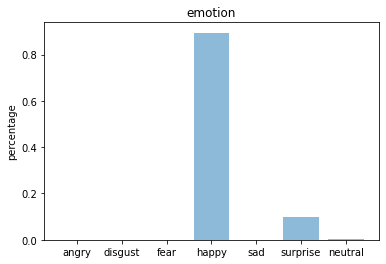

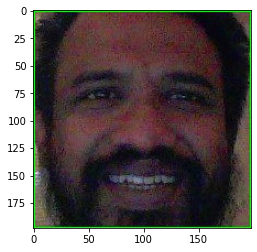

In [ ]:
#Test the captured image
facecrop(path+'/photo.jpg')
plotface(path+'/capture.jpg')